<a href="https://colab.research.google.com/github/peenalGupta/Data-Analytics-3-Labs/blob/main/13_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN - first tries

We are implementing a simple feed-forward GAN architecture on MNIST - just to get the feeling right.

## Loading data

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
(train_data,_),(test_data,_) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# The more the merrier :-)
# Remember, this is unsupervised learning, so "holdout" and such makes less sense
data = np.concatenate((train_data,test_data),axis=0)

In [4]:
data.shape

(70000, 28, 28)

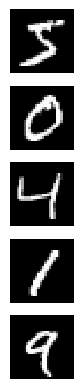

In [5]:
import matplotlib.pyplot as plt

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex], interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

In [6]:
# Normalization betwenn -1 and 1 !!!!
quasi_mean = data.max()/2 # Max is always 255, so this works ok.
data = (data.astype(np.float32)-quasi_mean)/quasi_mean

In [7]:
# Flattening of the image vectors
data = data.reshape(data.shape[0],-1)
data.shape

(70000, 784)

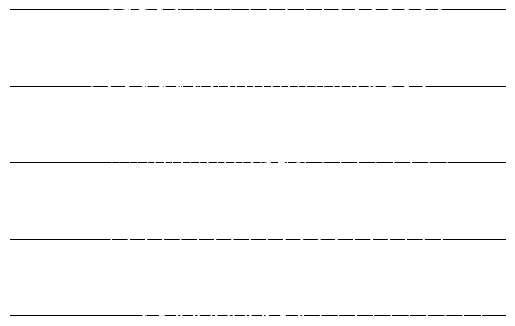

In [8]:
# Just to get the feeling, how bad this representation is...

example_count = 5

for ex in range(example_count):
    plt.subplot(5, example_count//5, ex+1)
    plt.imshow(data[ex].reshape(1,-1), interpolation="nearest", cmap="gray")
    plt.axis("off")

plt.show()

## Parameters

### Training parameters

We will be forced to do manual batching here, so we have to calcculate the number of batches manually, and iterate on a per batch basis.

In [9]:
EPOCHS = 30
BATCH_SIZE = 200
HALF_BATCH = BATCH_SIZE // 2
BATCH_NUM = (data.shape[0] // BATCH_SIZE)
if data.shape[0] % BATCH_SIZE:
    BATCH_NUM+=1
Z_DIM = 100


In [10]:
BATCH_NUM

350

### Model parameters

In [11]:
GENERATOR_L1_DIM = 256
GENERATOR_L2_DIM = 512
GENERATOR_L3_DIM = 1024

DISCRIMINATOR_L1_DIM = 512
DISCRIMINATOR_L2_DIM = 256

LEAKY_ALPHA = 0.2

## Model building

In [13]:
import tensorflow as tf
# Some empirically set values.
# It might well be worth experimenting with newer optimizers / settings

#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, beta_1=0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

### Generator

In [14]:
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model

In [16]:
### Define the generator!
#########################

# We use FUNCTIONAL API!

# The generator always gets a noise vector as input
#TODO
noise_input = Input(shape=(Z_DIM,))

# Define the first layer of the fully connected network, without activation!
# Use the parameters defined with capital letter constants in the cells above for node counts!

#TODO
g_layer_1 = Dense(GENERATOR_L1_DIM)(noise_input)


# Define a non-linearioty, namely leaky relu on this layer!
# We use LeakyReLU for avoiding sparsity - other options are viable also, just not normal relu
# Use the alpha value defined in constants above!

#TODO
g_layer_1_nonlin = LeakyReLU(negative_slope=LEAKY_ALPHA)(g_layer_1)

# You can do this as one layer, but now we do it in two. Does not matter.

# Repeat the process two more times!
#TODO
g_layer_2 = Dense(GENERATOR_L2_DIM)(g_layer_1_nonlin)
g_layer_2_nonlin = LeakyReLU(negative_slope=LEAKY_ALPHA)(g_layer_2)

#TODO
## updated the use of alpha = to negative_slope = in above code as alpha is deprecated
###did the same for all below code
#g_layer_2_nonlin = LeakyReLU(alpha=LEAKY_ALPHA)(g_layer_2)


#TODO
g_layer_3 = Dense(GENERATOR_L3_DIM)(g_layer_2_nonlin)
g_layer_3_nonlin = LeakyReLU(negative_slope=LEAKY_ALPHA)(g_layer_3)

# The output of the generator is a flattened image
# Remeber, we normalized everything between -1 and +1, so what is a nice nonlinearity, bounded between
# -1 and 1?
# Use that one as an activation for the final fully connected layer!

#TODO
g_output_layer = Dense(data.shape[1], activation='tanh')(g_layer_3_nonlin)

# Please instantiate the model!
#TODO
generator = Model(inputs=noise_input, outputs=g_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!

generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# Think about this carefully, please!

In [23]:
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 784)                 │         803,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

### Discriminator

In [18]:
### Define the discriminator!
#############################

# We still use FUNCTIONAL API!

# The discriminator always gets (flattened) images as inputs
# Where can you find the flattened dimensions?
# Please use a variable or property, not a hand "baked in" constant.
# That will mess up your life if the data changes...

#TODO
image_input = Input(shape=(data.shape[1],))


# Following the design pattern from above, please implement two layers with nonlinearities!
#TODO
d_layer_1 = Dense(DISCRIMINATOR_L1_DIM)(image_input)
d_layer_1_nonlin = LeakyReLU(negative_slope=LEAKY_ALPHA)(d_layer_1)

d_layer_2 = Dense(DISCRIMINATOR_L2_DIM)(d_layer_1_nonlin)
d_layer_2_nonlin = LeakyReLU(negative_slope=LEAKY_ALPHA)(d_layer_2)
# Please implement the output layer!
# The output of the discriminator is a single binary decision,
# so one use an appropriate activation and dimensionality!
#TODO
d_output_layer = Dense(1, activation='sigmoid')(d_layer_2_nonlin)  # Sigmoid for binary classification


# Please instantiate the model!
#TODO
discriminator = Model(inputs=image_input, outputs=d_output_layer)

# Please remeber, that the loss for the discriminator will be a binary loss, so this applies here also
# Use the appropriate loss measure!

#TODO
discriminator.compile(loss= 'binary_crossentropy', optimizer=optimizer)

In [22]:
discriminator.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 533,505 (2.04 MB)

### Joint model

In [19]:
### Define the GAN itself!
##########################


# STOP!!!!!!
# This is a crucial line, since in the joint model, discriminator will be frozen, so no weight update!
discriminator.trainable = False

#TODO


# We are freezing the discriminator's weights during the joint model training
# to ensure that only the generator's weights are updated. This is because
# we want the generator to learn to generate images that can fool the
# discriminator, while the discriminator is kept constant to provide a
# stable target for the generator to learn from.

# Remove this .... if you understand, why the above line is here!

# What is the input for the whole GAN?
# Think about the case, when the generator generates, the discriminator only discriminates it's output!
#TODO
gan_input = noise_input
# Use the generator as a function on the input!
generated_image = generator(gan_input)  # Generator generates image from noise


# Use the discriminator as a function on the fake images!
#TODO
gan_output = discriminator(generated_image) # Discriminator classifies the generated image

# Instantiate the joint model, appropriate input and output!
#TODO
joint_model = Model(inputs=gan_input, outputs=gan_output)
# Please think about, why it can be true, that for the joint model a binary decision is still adequate!
joint_model.compile(loss='binary_crossentropy', optimizer=optimizer)
# Maybe it will get clear below in the training loop...

In [21]:
joint_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 784)                 │       1,486,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 1)                   │         533,505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,019,857 (7.71 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 533,505 (2.04 MB)

## Helper functions for visualization

In [24]:
# Nothing to see here! :-P

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


def get_example_images(epoch, example_count=25):
    input_noise = np.random.normal(0,1, size=(example_count,Z_DIM))
    generated_images = generator.predict(input_noise)
    generated_images = generated_images.reshape(example_count, 28, 28)

    plt.figure(figsize = (5, example_count // 5))
    for ex in range(example_count):
        plt.subplot(5, example_count//5, ex+1)
        plt.imshow(generated_images[ex], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("example_images_epoch_num_{0}.png".format(epoch))

def show_image_for_epoch(epoch):
    imgname = "example_images_epoch_num_"+str(epoch)+".png"
    img = mpimg.imread(imgname)
    imgplot = plt.imshow(img)
    plt.show()


## Training

Sadly, we can not use simple `fit()`, but have to construct the main training loop ourselves.

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 1/350 [00:00<03:16,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  1%|          | 2/350 [00:01<03:07,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  1%|          | 3/350 [00:01<03:05,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  1%|          | 4/350 [00:02<03:10,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  1%|▏         | 5/350 [00:02<03:11,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  2%|▏         | 6/350 [00:03<03:14,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  2%|▏         | 7/350 [00:03<03:14,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  2%|▏         | 8/350 [00:04<03:10,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  3%|▎         | 9/350 [00:04<03:05,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  3%|▎         | 10/350 [00:05<03:01,  1.87it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  3%|▎         | 11/350 [00:05<03:00,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  3%|▎         | 12/350 [00:06<03:04,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  4%|▎         | 13/350 [00:07<03:04,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  4%|▍         | 14/350 [00:07<03:03,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  4%|▍         | 15/350 [00:08<03:03,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  5%|▍         | 16/350 [00:08<03:05,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  5%|▍         | 17/350 [00:09<03:27,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|▌         | 18/350 [00:10<03:38,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|▌         | 19/350 [00:11<03:48,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  6%|▌         | 20/350 [00:11<04:00,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  6%|▌         | 21/350 [00:12<04:01,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  6%|▋         | 22/350 [00:13<03:41,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  7%|▋         | 23/350 [00:13<03:53,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  7%|▋         | 24/350 [00:14<03:39,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  7%|▋         | 25/350 [00:15<03:26,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  7%|▋         | 26/350 [00:15<03:18,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  8%|▊         | 27/350 [00:16<03:10,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  8%|▊         | 28/350 [00:16<03:06,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  8%|▊         | 29/350 [00:17<02:58,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  9%|▊         | 30/350 [00:17<02:58,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  9%|▉         | 31/350 [00:18<02:57,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  9%|▉         | 32/350 [00:18<02:57,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  9%|▉         | 33/350 [00:19<02:53,  1.83it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 10%|▉         | 34/350 [00:19<02:51,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 10%|█         | 35/350 [00:20<02:52,  1.82it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 10%|█         | 36/350 [00:21<02:50,  1.85it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 11%|█         | 37/350 [00:21<02:46,  1.88it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 11%|█         | 38/350 [00:22<02:45,  1.89it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 11%|█         | 39/350 [00:22<03:05,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 11%|█▏        | 40/350 [00:23<03:26,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▏        | 41/350 [00:24<03:42,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 12%|█▏        | 42/350 [00:25<03:58,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▏        | 43/350 [00:26<03:47,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 13%|█▎        | 44/350 [00:26<03:30,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 13%|█▎        | 45/350 [00:27<03:19,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 13%|█▎        | 46/350 [00:27<03:05,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 13%|█▎        | 47/350 [00:28<02:58,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 14%|█▎        | 48/350 [00:28<02:55,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 14%|█▍        | 49/350 [00:29<02:52,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 14%|█▍        | 50/350 [00:29<02:49,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 15%|█▍        | 51/350 [00:30<02:49,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 15%|█▍        | 52/350 [00:31<02:48,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 15%|█▌        | 53/350 [00:31<02:47,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 15%|█▌        | 54/350 [00:32<02:58,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|█▌        | 55/350 [00:32<02:54,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|█▌        | 56/350 [00:33<02:55,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|█▋        | 57/350 [00:34<02:50,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 17%|█▋        | 58/350 [00:34<02:48,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 17%|█▋        | 59/350 [00:35<02:42,  1.80it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 17%|█▋        | 60/350 [00:35<02:42,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 17%|█▋        | 61/350 [00:36<03:08,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 18%|█▊        | 62/350 [00:37<03:21,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 18%|█▊        | 63/350 [00:38<03:30,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 18%|█▊        | 64/350 [00:39<03:38,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 19%|█▊        | 65/350 [00:39<03:25,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 19%|█▉        | 66/350 [00:40<03:08,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 19%|█▉        | 67/350 [00:40<02:57,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 19%|█▉        | 68/350 [00:41<02:48,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 20%|█▉        | 69/350 [00:41<02:47,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 20%|██        | 70/350 [00:42<02:46,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 20%|██        | 71/350 [00:42<02:43,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 21%|██        | 72/350 [00:43<02:42,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 21%|██        | 73/350 [00:44<02:35,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 21%|██        | 74/350 [00:44<02:30,  1.84it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 21%|██▏       | 75/350 [00:45<02:31,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 22%|██▏       | 76/350 [00:45<02:34,  1.77it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 22%|██▏       | 77/350 [00:46<02:32,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 22%|██▏       | 78/350 [00:46<02:32,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 23%|██▎       | 79/350 [00:47<02:32,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 23%|██▎       | 80/350 [00:47<02:29,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 23%|██▎       | 81/350 [00:48<02:31,  1.78it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 23%|██▎       | 82/350 [00:49<02:28,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 24%|██▎       | 83/350 [00:49<02:41,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 24%|██▍       | 84/350 [00:50<03:00,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 24%|██▍       | 85/350 [00:51<03:14,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 25%|██▍       | 86/350 [00:52<03:24,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 25%|██▍       | 87/350 [00:53<03:17,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 25%|██▌       | 88/350 [00:53<03:04,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 25%|██▌       | 89/350 [00:54<02:52,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 26%|██▌       | 90/350 [00:54<02:40,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 26%|██▌       | 91/350 [00:55<02:35,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 26%|██▋       | 92/350 [00:55<02:33,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 27%|██▋       | 93/350 [00:56<02:31,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 27%|██▋       | 94/350 [00:57<02:26,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 27%|██▋       | 95/350 [00:57<02:25,  1.75it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 27%|██▋       | 96/350 [00:58<02:20,  1.81it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 28%|██▊       | 97/350 [00:58<02:23,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 28%|██▊       | 98/350 [00:59<02:20,  1.79it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 28%|██▊       | 99/350 [01:00<02:40,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 29%|██▊       | 100/350 [01:00<02:36,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 29%|██▉       | 101/350 [01:01<02:32,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 29%|██▉       | 102/350 [01:01<02:25,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 29%|██▉       | 103/350 [01:02<02:22,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 30%|██▉       | 104/350 [01:02<02:24,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|███       | 105/350 [01:03<02:42,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 30%|███       | 106/350 [01:04<02:49,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|███       | 107/350 [01:05<03:01,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 31%|███       | 108/350 [01:06<03:00,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 31%|███       | 109/350 [01:06<02:46,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 31%|███▏      | 110/350 [01:07<02:36,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 32%|███▏      | 111/350 [01:07<02:32,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 32%|███▏      | 112/350 [01:08<02:29,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 32%|███▏      | 113/350 [01:09<02:26,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 33%|███▎      | 114/350 [01:09<02:24,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 33%|███▎      | 115/350 [01:10<02:23,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 33%|███▎      | 116/350 [01:10<02:22,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 33%|███▎      | 117/350 [01:11<02:23,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 34%|███▎      | 118/350 [01:12<02:22,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 34%|███▍      | 119/350 [01:12<02:19,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 34%|███▍      | 120/350 [01:13<02:14,  1.71it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 35%|███▍      | 121/350 [01:13<02:11,  1.74it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 35%|███▍      | 122/350 [01:14<02:09,  1.76it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 35%|███▌      | 123/350 [01:14<02:12,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 35%|███▌      | 124/350 [01:15<02:10,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 36%|███▌      | 125/350 [01:16<02:10,  1.73it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 36%|███▌      | 126/350 [01:16<02:26,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 36%|███▋      | 127/350 [01:17<02:37,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 37%|███▋      | 128/350 [01:18<02:48,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 37%|███▋      | 129/350 [01:19<02:53,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 37%|███▋      | 130/350 [01:20<02:37,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 37%|███▋      | 131/350 [01:20<02:29,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 38%|███▊      | 132/350 [01:21<02:24,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 38%|███▊      | 133/350 [01:21<02:18,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 38%|███▊      | 134/350 [01:22<02:12,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 39%|███▊      | 135/350 [01:22<02:07,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 39%|███▉      | 136/350 [01:23<02:26,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 39%|███▉      | 137/350 [01:24<02:18,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 39%|███▉      | 138/350 [01:25<02:14,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 40%|███▉      | 139/350 [01:25<02:10,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 40%|████      | 140/350 [01:26<02:08,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 40%|████      | 141/350 [01:26<02:07,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 41%|████      | 142/350 [01:27<02:03,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 41%|████      | 143/350 [01:27<02:01,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 41%|████      | 144/350 [01:28<02:00,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 41%|████▏     | 145/350 [01:29<02:02,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 42%|████▏     | 146/350 [01:29<02:14,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 42%|████▏     | 147/350 [01:30<02:27,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 42%|████▏     | 148/350 [01:31<02:38,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 43%|████▎     | 149/350 [01:32<02:48,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 43%|████▎     | 150/350 [01:33<02:40,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 43%|████▎     | 151/350 [01:33<02:26,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 43%|████▎     | 152/350 [01:34<02:15,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 44%|████▎     | 153/350 [01:35<02:10,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 44%|████▍     | 154/350 [01:35<02:07,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 44%|████▍     | 155/350 [01:36<02:06,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 45%|████▍     | 156/350 [01:37<02:03,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 45%|████▍     | 157/350 [01:37<01:59,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 45%|████▌     | 158/350 [01:38<01:56,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 45%|████▌     | 159/350 [01:38<01:55,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 46%|████▌     | 160/350 [01:39<01:54,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████▌     | 161/350 [01:40<01:54,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████▋     | 162/350 [01:40<01:52,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 47%|████▋     | 163/350 [01:41<01:52,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 47%|████▋     | 164/350 [01:41<01:53,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 47%|████▋     | 165/350 [01:42<01:54,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 47%|████▋     | 166/350 [01:43<01:51,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 48%|████▊     | 167/350 [01:44<02:13,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 48%|████▊     | 168/350 [01:44<02:22,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 48%|████▊     | 169/350 [01:45<02:30,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 49%|████▊     | 170/350 [01:46<02:27,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 49%|████▉     | 171/350 [01:47<02:15,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 49%|████▉     | 172/350 [01:47<02:06,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 49%|████▉     | 173/350 [01:48<02:00,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|████▉     | 174/350 [01:49<01:55,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|█████     | 175/350 [01:49<01:52,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 50%|█████     | 176/350 [01:50<01:48,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 51%|█████     | 177/350 [01:50<01:46,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 51%|█████     | 178/350 [01:51<01:47,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 51%|█████     | 179/350 [01:52<01:45,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 51%|█████▏    | 180/350 [01:52<01:45,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████▏    | 181/350 [01:53<01:44,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 52%|█████▏    | 182/350 [01:54<01:42,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████▏    | 183/350 [01:54<01:43,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 53%|█████▎    | 184/350 [01:55<01:43,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 53%|█████▎    | 185/350 [01:55<01:41,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 53%|█████▎    | 186/350 [01:56<01:41,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 187/350 [01:57<02:00,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 54%|█████▎    | 188/350 [01:58<02:08,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 54%|█████▍    | 189/350 [01:59<02:17,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 54%|█████▍    | 190/350 [02:00<02:14,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|█████▍    | 191/350 [02:00<02:01,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|█████▍    | 192/350 [02:01<01:51,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 55%|█████▌    | 193/350 [02:01<01:44,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 55%|█████▌    | 194/350 [02:02<01:41,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 56%|█████▌    | 195/350 [02:03<01:37,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 56%|█████▌    | 196/350 [02:03<01:37,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 56%|█████▋    | 197/350 [02:04<01:37,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 57%|█████▋    | 198/350 [02:05<01:33,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 57%|█████▋    | 199/350 [02:05<01:32,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 57%|█████▋    | 200/350 [02:06<01:30,  1.66it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 57%|█████▋    | 201/350 [02:06<01:29,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 58%|█████▊    | 202/350 [02:07<01:28,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 58%|█████▊    | 203/350 [02:07<01:25,  1.72it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 58%|█████▊    | 204/350 [02:08<01:26,  1.70it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|█████▊    | 205/350 [02:09<01:26,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|█████▉    | 206/350 [02:09<01:28,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 59%|█████▉    | 207/350 [02:10<01:39,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 59%|█████▉    | 208/350 [02:11<01:47,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 60%|█████▉    | 209/350 [02:12<01:53,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 60%|██████    | 210/350 [02:13<01:56,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 60%|██████    | 211/350 [02:13<01:44,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 61%|██████    | 212/350 [02:14<01:37,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 61%|██████    | 213/350 [02:15<01:32,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 61%|██████    | 214/350 [02:15<01:31,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 61%|██████▏   | 215/350 [02:16<01:26,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 62%|██████▏   | 216/350 [02:16<01:22,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 62%|██████▏   | 217/350 [02:17<01:20,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 62%|██████▏   | 218/350 [02:18<01:19,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 63%|██████▎   | 219/350 [02:18<01:20,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 63%|██████▎   | 220/350 [02:19<01:19,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 63%|██████▎   | 221/350 [02:19<01:18,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 63%|██████▎   | 222/350 [02:20<01:16,  1.67it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 64%|██████▎   | 223/350 [02:21<01:15,  1.69it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 64%|██████▍   | 224/350 [02:21<01:15,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 64%|██████▍   | 225/350 [02:22<01:14,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 65%|██████▍   | 226/350 [02:22<01:13,  1.68it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 65%|██████▍   | 227/350 [02:23<01:18,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 65%|██████▌   | 228/350 [02:24<01:25,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 65%|██████▌   | 229/350 [02:25<01:30,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 66%|██████▌   | 230/350 [02:26<01:35,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 66%|██████▌   | 231/350 [02:26<01:30,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 66%|██████▋   | 232/350 [02:27<01:23,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 67%|██████▋   | 233/350 [02:28<01:20,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 67%|██████▋   | 234/350 [02:28<01:19,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 67%|██████▋   | 235/350 [02:29<01:16,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 67%|██████▋   | 236/350 [02:30<01:12,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 68%|██████▊   | 237/350 [02:30<01:10,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 68%|██████▊   | 238/350 [02:31<01:08,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 68%|██████▊   | 239/350 [02:31<01:07,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 69%|██████▊   | 240/350 [02:32<01:07,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 69%|██████▉   | 241/350 [02:33<01:07,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 69%|██████▉   | 242/350 [02:33<01:06,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 69%|██████▉   | 243/350 [02:34<01:06,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 70%|██████▉   | 244/350 [02:34<01:06,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 70%|███████   | 245/350 [02:35<01:06,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 70%|███████   | 246/350 [02:36<01:06,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 71%|███████   | 247/350 [02:37<01:10,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 71%|███████   | 248/350 [02:37<01:16,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 71%|███████   | 249/350 [02:38<01:23,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 71%|███████▏  | 250/350 [02:39<01:27,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 72%|███████▏  | 251/350 [02:40<01:19,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 72%|███████▏  | 252/350 [02:41<01:13,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 72%|███████▏  | 253/350 [02:41<01:08,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 73%|███████▎  | 254/350 [02:42<01:05,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 73%|███████▎  | 255/350 [02:43<01:03,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 73%|███████▎  | 256/350 [02:43<01:01,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 73%|███████▎  | 257/350 [02:44<00:59,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 74%|███████▎  | 258/350 [02:44<00:59,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 74%|███████▍  | 259/350 [02:45<00:59,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 74%|███████▍  | 260/350 [02:46<00:59,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 75%|███████▍  | 261/350 [02:47<00:59,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 75%|███████▍  | 262/350 [02:47<00:57,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 75%|███████▌  | 263/350 [02:48<00:56,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 75%|███████▌  | 264/350 [02:49<01:12,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|███████▌  | 265/350 [02:50<01:12,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 76%|███████▌  | 266/350 [02:51<01:14,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 76%|███████▋  | 267/350 [02:52<01:13,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 77%|███████▋  | 268/350 [02:53<01:14,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 77%|███████▋  | 269/350 [02:53<01:07,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 77%|███████▋  | 270/350 [02:54<01:01,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 77%|███████▋  | 271/350 [02:55<00:57,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 78%|███████▊  | 272/350 [02:55<00:54,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 78%|███████▊  | 273/350 [02:56<00:52,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 78%|███████▊  | 274/350 [02:57<00:50,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 79%|███████▊  | 275/350 [02:57<00:49,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 79%|███████▉  | 276/350 [02:58<00:48,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 79%|███████▉  | 277/350 [02:59<00:48,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 79%|███████▉  | 278/350 [02:59<00:47,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 80%|███████▉  | 279/350 [03:00<00:45,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 80%|████████  | 280/350 [03:00<00:43,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 80%|████████  | 281/350 [03:01<00:42,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 81%|████████  | 282/350 [03:02<00:41,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 81%|████████  | 283/350 [03:02<00:41,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 81%|████████  | 284/350 [03:03<00:42,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 81%|████████▏ | 285/350 [03:04<00:48,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 82%|████████▏ | 286/350 [03:05<00:53,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 82%|████████▏ | 287/350 [03:06<00:55,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 82%|████████▏ | 288/350 [03:07<00:51,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 83%|████████▎ | 289/350 [03:07<00:47,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 83%|████████▎ | 290/350 [03:08<00:43,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 83%|████████▎ | 291/350 [03:09<00:41,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 83%|████████▎ | 292/350 [03:09<00:39,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 84%|████████▎ | 293/350 [03:10<00:37,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 84%|████████▍ | 294/350 [03:10<00:35,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 84%|████████▍ | 295/350 [03:11<00:35,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 85%|████████▍ | 296/350 [03:12<00:35,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 85%|████████▍ | 297/350 [03:12<00:34,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|████████▌ | 298/350 [03:13<00:34,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|████████▌ | 299/350 [03:14<00:33,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 86%|████████▌ | 300/350 [03:14<00:33,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 86%|████████▌ | 301/350 [03:15<00:33,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 86%|████████▋ | 302/350 [03:16<00:32,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 87%|████████▋ | 303/350 [03:17<00:33,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 87%|████████▋ | 304/350 [03:18<00:37,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 87%|████████▋ | 305/350 [03:19<00:39,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 87%|████████▋ | 306/350 [03:20<00:40,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 88%|████████▊ | 307/350 [03:20<00:37,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 88%|████████▊ | 308/350 [03:21<00:34,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 88%|████████▊ | 309/350 [03:22<00:31,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 89%|████████▊ | 310/350 [03:22<00:28,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 89%|████████▉ | 311/350 [03:23<00:27,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 89%|████████▉ | 312/350 [03:24<00:26,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 89%|████████▉ | 313/350 [03:24<00:25,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 90%|████████▉ | 314/350 [03:25<00:24,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 90%|█████████ | 315/350 [03:26<00:23,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 90%|█████████ | 316/350 [03:26<00:22,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 91%|█████████ | 317/350 [03:27<00:21,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 91%|█████████ | 318/350 [03:28<00:21,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 91%|█████████ | 319/350 [03:28<00:20,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 91%|█████████▏| 320/350 [03:29<00:19,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 92%|█████████▏| 321/350 [03:30<00:18,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 92%|█████████▏| 322/350 [03:31<00:20,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 92%|█████████▏| 323/350 [03:32<00:22,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 324/350 [03:33<00:23,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 93%|█████████▎| 325/350 [03:34<00:22,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 93%|█████████▎| 326/350 [03:34<00:19,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 93%|█████████▎| 327/350 [03:35<00:17,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 94%|█████████▎| 328/350 [03:35<00:15,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 94%|█████████▍| 329/350 [03:36<00:14,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 94%|█████████▍| 330/350 [03:37<00:13,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 95%|█████████▍| 331/350 [03:37<00:13,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 95%|█████████▍| 332/350 [03:38<00:12,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 95%|█████████▌| 333/350 [03:39<00:11,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 95%|█████████▌| 334/350 [03:39<00:10,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 96%|█████████▌| 335/350 [03:40<00:09,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 96%|█████████▌| 336/350 [03:41<00:08,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 96%|█████████▋| 337/350 [03:41<00:08,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 97%|█████████▋| 338/350 [03:42<00:07,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 97%|█████████▋| 339/350 [03:42<00:06,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 97%|█████████▋| 340/350 [03:43<00:06,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 97%|█████████▋| 341/350 [03:44<00:06,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 98%|█████████▊| 342/350 [03:45<00:06,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 98%|█████████▊| 343/350 [03:46<00:06,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 98%|█████████▊| 344/350 [03:47<00:05,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 99%|█████████▊| 345/350 [03:48<00:04,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 99%|█████████▉| 346/350 [03:48<00:03,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 99%|█████████▉| 347/350 [03:49<00:02,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 99%|█████████▉| 348/350 [03:50<00:01,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


100%|█████████▉| 349/350 [03:50<00:00,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


100%|██████████| 350/350 [03:51<00:00,  1.51it/s]


Epoch number: 0 discriminator_loss: 3.377607124703271 generator_loss: 3.3867518986974443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


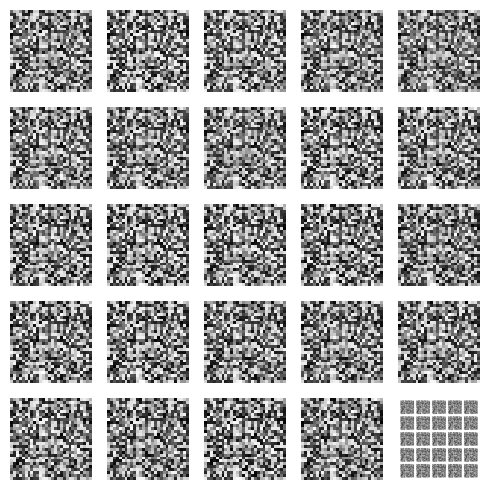

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 1/350 [00:00<03:46,  1.54it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  1%|          | 2/350 [00:01<03:41,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  1%|          | 3/350 [00:01<03:41,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  1%|          | 4/350 [00:02<03:38,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|▏         | 5/350 [00:03<03:38,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  2%|▏         | 6/350 [00:03<03:45,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  2%|▏         | 7/350 [00:04<03:50,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  2%|▏         | 8/350 [00:05<04:29,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|▎         | 9/350 [00:06<04:48,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


  3%|▎         | 10/350 [00:07<05:22,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 11/350 [00:08<05:11,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  3%|▎         | 12/350 [00:09<04:44,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  4%|▎         | 13/350 [00:09<04:26,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  4%|▍         | 14/350 [00:10<04:19,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  4%|▍         | 15/350 [00:11<04:12,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|▍         | 16/350 [00:12<04:06,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  5%|▍         | 17/350 [00:12<03:55,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|▌         | 18/350 [00:13<03:55,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|▌         | 19/350 [00:14<03:53,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  6%|▌         | 20/350 [00:14<03:49,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  6%|▌         | 21/350 [00:15<03:47,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  6%|▋         | 22/350 [00:16<03:47,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  7%|▋         | 23/350 [00:16<03:42,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  7%|▋         | 24/350 [00:17<03:42,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  7%|▋         | 25/350 [00:18<03:42,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  7%|▋         | 26/350 [00:19<04:15,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  8%|▊         | 27/350 [00:20<04:41,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  8%|▊         | 28/350 [00:21<04:59,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  8%|▊         | 29/350 [00:22<04:46,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  9%|▊         | 30/350 [00:22<04:30,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  9%|▉         | 31/350 [00:23<04:18,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  9%|▉         | 32/350 [00:24<04:04,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  9%|▉         | 33/350 [00:24<03:54,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 10%|▉         | 34/350 [00:25<03:50,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 10%|█         | 35/350 [00:26<03:44,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 10%|█         | 36/350 [00:27<03:40,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 11%|█         | 37/350 [00:27<03:43,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 11%|█         | 38/350 [00:28<03:41,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 11%|█         | 39/350 [00:29<03:43,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 11%|█▏        | 40/350 [00:29<03:40,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 12%|█▏        | 41/350 [00:30<03:34,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 12%|█▏        | 42/350 [00:32<04:59,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 12%|█▏        | 43/350 [00:33<05:07,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 13%|█▎        | 44/350 [00:34<05:08,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 13%|█▎        | 45/350 [00:35<05:01,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 13%|█▎        | 46/350 [00:35<04:29,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 13%|█▎        | 47/350 [00:36<04:14,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 14%|█▎        | 48/350 [00:37<04:02,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 14%|█▍        | 49/350 [00:38<03:49,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 14%|█▍        | 50/350 [00:38<03:40,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 15%|█▍        | 51/350 [00:39<03:33,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 15%|█▍        | 52/350 [00:39<03:26,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 15%|█▌        | 53/350 [00:40<03:21,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 15%|█▌        | 54/350 [00:41<03:20,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 16%|█▌        | 55/350 [00:42<03:23,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 16%|█▌        | 56/350 [00:42<03:28,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|█▋        | 57/350 [00:43<03:28,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 17%|█▋        | 58/350 [00:44<03:25,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 17%|█▋        | 59/350 [00:44<03:24,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 17%|█▋        | 60/350 [00:45<03:57,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 17%|█▋        | 61/350 [00:47<04:18,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 18%|█▊        | 62/350 [00:48<04:31,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 18%|█▊        | 63/350 [00:48<04:15,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 18%|█▊        | 64/350 [00:49<03:55,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 19%|█▊        | 65/350 [00:50<03:45,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 19%|█▉        | 66/350 [00:50<03:40,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 19%|█▉        | 67/350 [00:51<03:36,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 19%|█▉        | 68/350 [00:52<03:24,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 20%|█▉        | 69/350 [00:53<03:23,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 20%|██        | 70/350 [00:53<03:25,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 20%|██        | 71/350 [00:54<03:18,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 21%|██        | 72/350 [00:55<03:14,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 21%|██        | 73/350 [00:55<03:12,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 21%|██        | 74/350 [00:56<03:10,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 21%|██▏       | 75/350 [00:57<03:08,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 22%|██▏       | 76/350 [00:57<03:09,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 22%|██▏       | 77/350 [00:58<03:27,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 22%|██▏       | 78/350 [00:59<03:50,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 23%|██▎       | 79/350 [01:01<04:12,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 23%|██▎       | 80/350 [01:02<04:16,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██▎       | 81/350 [01:02<03:58,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 23%|██▎       | 82/350 [01:03<03:41,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 24%|██▎       | 83/350 [01:04<03:30,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 24%|██▍       | 84/350 [01:04<03:24,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 24%|██▍       | 85/350 [01:05<03:18,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 25%|██▍       | 86/350 [01:06<03:14,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 25%|██▍       | 87/350 [01:07<03:17,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 25%|██▌       | 88/350 [01:07<03:12,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 25%|██▌       | 89/350 [01:08<03:05,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 26%|██▌       | 90/350 [01:09<03:03,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 26%|██▌       | 91/350 [01:09<03:06,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 26%|██▋       | 92/350 [01:10<03:06,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 27%|██▋       | 93/350 [01:11<03:00,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 27%|██▋       | 94/350 [01:11<02:57,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 27%|██▋       | 95/350 [01:13<03:30,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 27%|██▋       | 96/350 [01:14<03:47,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 28%|██▊       | 97/350 [01:15<04:04,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 28%|██▊       | 98/350 [01:16<03:58,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 28%|██▊       | 99/350 [01:16<03:38,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 29%|██▊       | 100/350 [01:17<03:21,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 29%|██▉       | 101/350 [01:18<03:11,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 29%|██▉       | 102/350 [01:18<03:08,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 29%|██▉       | 103/350 [01:19<03:03,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 30%|██▉       | 104/350 [01:20<03:03,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|███       | 105/350 [01:21<03:01,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 30%|███       | 106/350 [01:21<03:00,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 31%|███       | 107/350 [01:22<02:58,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|███       | 108/350 [01:23<02:54,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|███       | 109/350 [01:23<02:50,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|███▏      | 110/350 [01:24<02:48,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 32%|███▏      | 111/350 [01:25<02:44,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 32%|███▏      | 112/350 [01:26<03:00,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 32%|███▏      | 113/350 [01:27<03:19,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 33%|███▎      | 114/350 [01:28<03:42,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 33%|███▎      | 115/350 [01:29<03:37,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 33%|███▎      | 116/350 [01:30<03:22,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 33%|███▎      | 117/350 [01:30<03:13,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 34%|███▎      | 118/350 [01:31<03:07,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 34%|███▍      | 119/350 [01:32<02:58,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 34%|███▍      | 120/350 [01:32<02:57,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 35%|███▍      | 121/350 [01:33<02:55,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 35%|███▍      | 122/350 [01:34<02:55,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 35%|███▌      | 123/350 [01:35<02:54,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 35%|███▌      | 124/350 [01:36<02:51,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 36%|███▌      | 125/350 [01:36<02:49,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 36%|███▌      | 126/350 [01:37<02:45,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 36%|███▋      | 127/350 [01:38<02:46,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 37%|███▋      | 128/350 [01:39<02:51,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 37%|███▋      | 129/350 [01:40<03:16,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 37%|███▋      | 130/350 [01:41<03:42,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 37%|███▋      | 131/350 [01:42<03:40,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 38%|███▊      | 132/350 [01:43<03:19,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 38%|███▊      | 133/350 [01:43<03:04,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 38%|███▊      | 134/350 [01:44<02:52,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 39%|███▊      | 135/350 [01:45<02:48,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 39%|███▉      | 136/350 [01:46<02:47,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 39%|███▉      | 137/350 [01:46<02:44,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 39%|███▉      | 138/350 [01:47<02:43,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 40%|███▉      | 139/350 [01:48<02:42,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 40%|████      | 140/350 [01:49<02:40,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 40%|████      | 141/350 [01:49<02:39,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 41%|████      | 142/350 [01:50<02:38,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 41%|████      | 143/350 [01:51<02:34,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 41%|████      | 144/350 [01:52<02:31,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 41%|████▏     | 145/350 [01:53<02:51,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 42%|████▏     | 146/350 [01:54<03:11,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 42%|████▏     | 147/350 [01:55<03:25,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 42%|████▏     | 148/350 [01:56<03:16,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 43%|████▎     | 149/350 [01:57<02:59,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 43%|████▎     | 150/350 [01:57<02:54,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 43%|████▎     | 151/350 [01:58<02:48,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 43%|████▎     | 152/350 [01:59<02:43,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 44%|████▎     | 153/350 [02:00<02:38,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 44%|████▍     | 154/350 [02:01<02:36,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 44%|████▍     | 155/350 [02:01<02:32,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 45%|████▍     | 156/350 [02:02<02:27,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▍     | 157/350 [02:03<02:26,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 45%|████▌     | 158/350 [02:04<02:24,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 45%|████▌     | 159/350 [02:04<02:24,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████▌     | 160/350 [02:05<02:22,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████▌     | 161/350 [02:06<02:33,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 46%|████▋     | 162/350 [02:07<02:45,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 47%|████▋     | 163/350 [02:08<02:54,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 47%|████▋     | 164/350 [02:09<02:55,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 47%|████▋     | 165/350 [02:10<02:41,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 47%|████▋     | 166/350 [02:11<02:35,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 48%|████▊     | 167/350 [02:11<02:31,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 48%|████▊     | 168/350 [02:12<02:27,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 48%|████▊     | 169/350 [02:13<02:22,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 49%|████▊     | 170/350 [02:14<02:17,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 49%|████▉     | 171/350 [02:14<02:14,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 49%|████▉     | 172/350 [02:15<02:14,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 49%|████▉     | 173/350 [02:16<02:12,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|████▉     | 174/350 [02:16<02:09,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|█████     | 175/350 [02:17<02:08,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 50%|█████     | 176/350 [02:18<02:04,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 51%|█████     | 177/350 [02:19<02:03,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 51%|█████     | 178/350 [02:19<02:13,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 51%|█████     | 179/350 [02:21<02:26,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 51%|█████▏    | 180/350 [02:22<02:40,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 52%|█████▏    | 181/350 [02:23<02:38,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████▏    | 182/350 [02:23<02:27,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████▏    | 183/350 [02:24<02:18,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 53%|█████▎    | 184/350 [02:25<02:11,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 53%|█████▎    | 185/350 [02:25<02:06,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 53%|█████▎    | 186/350 [02:26<02:03,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 53%|█████▎    | 187/350 [02:27<02:02,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 54%|█████▎    | 188/350 [02:28<02:03,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 54%|█████▍    | 189/350 [02:28<02:03,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 54%|█████▍    | 190/350 [02:29<01:59,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|█████▍    | 191/350 [02:30<01:59,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 55%|█████▍    | 192/350 [02:31<01:59,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 55%|█████▌    | 193/350 [02:31<01:56,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|█████▌    | 194/350 [02:32<01:57,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 56%|█████▌    | 195/350 [02:33<02:11,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 56%|█████▌    | 196/350 [02:34<02:21,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 56%|█████▋    | 197/350 [02:36<02:34,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 57%|█████▋    | 198/350 [02:36<02:21,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 57%|█████▋    | 199/350 [02:37<02:12,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 57%|█████▋    | 200/350 [02:38<02:08,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 57%|█████▋    | 201/350 [02:39<02:04,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 58%|█████▊    | 202/350 [02:39<02:01,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 58%|█████▊    | 203/350 [02:40<01:59,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 58%|█████▊    | 204/350 [02:41<01:56,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 59%|█████▊    | 205/350 [02:42<01:52,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 59%|█████▉    | 206/350 [02:42<01:49,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|█████▉    | 207/350 [02:43<01:47,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|█████▉    | 208/350 [02:44<01:45,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 60%|█████▉    | 209/350 [02:45<01:42,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 60%|██████    | 210/350 [02:45<01:42,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 60%|██████    | 211/350 [02:46<01:54,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 61%|██████    | 212/350 [02:47<02:02,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 61%|██████    | 213/350 [02:49<02:13,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 61%|██████    | 214/350 [02:49<02:06,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 61%|██████▏   | 215/350 [02:50<01:57,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 62%|██████▏   | 216/350 [02:51<01:49,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 62%|██████▏   | 217/350 [02:52<01:48,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 62%|██████▏   | 218/350 [02:52<01:47,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 63%|██████▎   | 219/350 [02:53<01:45,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 63%|██████▎   | 220/350 [02:54<01:42,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 63%|██████▎   | 221/350 [02:55<01:41,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 63%|██████▎   | 222/350 [02:56<01:42,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 64%|██████▎   | 223/350 [02:56<01:40,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 64%|██████▍   | 224/350 [02:57<01:36,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 64%|██████▍   | 225/350 [02:58<01:34,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 65%|██████▍   | 226/350 [02:59<01:32,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 65%|██████▍   | 227/350 [03:00<01:43,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 65%|██████▌   | 228/350 [03:01<01:58,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 65%|██████▌   | 229/350 [03:02<02:06,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 66%|██████▌   | 230/350 [03:03<01:56,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 66%|██████▌   | 231/350 [03:04<01:48,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 66%|██████▋   | 232/350 [03:04<01:42,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 67%|██████▋   | 233/350 [03:05<01:37,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 67%|██████▋   | 234/350 [03:06<01:35,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 67%|██████▋   | 235/350 [03:07<01:34,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 67%|██████▋   | 236/350 [03:08<01:31,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 68%|██████▊   | 237/350 [03:08<01:29,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 68%|██████▊   | 238/350 [03:09<01:28,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 68%|██████▊   | 239/350 [03:11<01:54,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 69%|██████▊   | 240/350 [03:11<01:43,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 69%|██████▉   | 241/350 [03:12<01:37,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 69%|██████▉   | 242/350 [03:13<01:43,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 69%|██████▉   | 243/350 [03:14<01:47,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 70%|██████▉   | 244/350 [03:16<01:55,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 70%|███████   | 245/350 [03:17<01:46,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 70%|███████   | 246/350 [03:17<01:37,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 71%|███████   | 247/350 [03:18<01:30,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 71%|███████   | 248/350 [03:19<01:26,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 71%|███████   | 249/350 [03:20<01:24,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 71%|███████▏  | 250/350 [03:20<01:20,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 72%|███████▏  | 251/350 [03:21<01:20,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 72%|███████▏  | 252/350 [03:22<01:19,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 72%|███████▏  | 253/350 [03:23<01:18,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 73%|███████▎  | 254/350 [03:24<01:18,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 73%|███████▎  | 255/350 [03:25<01:18,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 73%|███████▎  | 256/350 [03:25<01:17,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 73%|███████▎  | 257/350 [03:27<01:25,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 74%|███████▎  | 258/350 [03:28<01:30,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 74%|███████▍  | 259/350 [03:29<01:35,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 74%|███████▍  | 260/350 [03:30<01:30,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 75%|███████▍  | 261/350 [03:30<01:21,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 75%|███████▍  | 262/350 [03:31<01:17,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 75%|███████▌  | 263/350 [03:32<01:14,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 75%|███████▌  | 264/350 [03:33<01:10,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|███████▌  | 265/350 [03:34<01:09,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|███████▌  | 266/350 [03:34<01:07,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|███████▋  | 267/350 [03:35<01:06,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 77%|███████▋  | 268/350 [03:36<01:05,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 77%|███████▋  | 269/350 [03:37<01:04,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 77%|███████▋  | 270/350 [03:38<01:03,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 77%|███████▋  | 271/350 [03:38<01:02,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 78%|███████▊  | 272/350 [03:39<00:59,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 78%|███████▊  | 273/350 [03:40<01:03,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 78%|███████▊  | 274/350 [03:41<01:08,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 79%|███████▊  | 275/350 [03:42<01:14,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 79%|███████▉  | 276/350 [03:43<01:11,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 79%|███████▉  | 277/350 [03:44<01:06,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 79%|███████▉  | 278/350 [03:45<01:02,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 80%|███████▉  | 279/350 [03:46<00:59,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 80%|████████  | 280/350 [03:46<00:58,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 80%|████████  | 281/350 [03:47<00:55,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 81%|████████  | 282/350 [03:48<00:53,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 81%|████████  | 283/350 [03:49<00:52,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 81%|████████  | 284/350 [03:49<00:52,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 81%|████████▏ | 285/350 [03:50<00:50,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 82%|████████▏ | 286/350 [03:51<00:48,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 82%|████████▏ | 287/350 [03:52<00:47,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 82%|████████▏ | 288/350 [03:52<00:46,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 83%|████████▎ | 289/350 [03:53<00:50,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 83%|████████▎ | 290/350 [03:55<00:55,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 83%|████████▎ | 291/350 [03:56<00:58,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 83%|████████▎ | 292/350 [03:57<00:54,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 84%|████████▎ | 293/350 [03:57<00:50,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 84%|████████▍ | 294/350 [03:58<00:48,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 84%|████████▍ | 295/350 [03:59<00:47,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 85%|████████▍ | 296/350 [04:00<00:45,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|████████▍ | 297/350 [04:01<00:44,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 85%|████████▌ | 298/350 [04:01<00:43,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 85%|████████▌ | 299/350 [04:02<00:41,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 86%|████████▌ | 300/350 [04:03<00:39,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 86%|████████▌ | 301/350 [04:04<00:38,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 86%|████████▋ | 302/350 [04:04<00:38,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 87%|████████▋ | 303/350 [04:05<00:38,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 87%|████████▋ | 304/350 [04:06<00:38,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 87%|████████▋ | 305/350 [04:08<00:43,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 87%|████████▋ | 306/350 [04:09<00:46,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 88%|████████▊ | 307/350 [04:10<00:45,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 88%|████████▊ | 308/350 [04:11<00:41,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 88%|████████▊ | 309/350 [04:11<00:37,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 89%|████████▊ | 310/350 [04:12<00:35,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 89%|████████▉ | 311/350 [04:13<00:33,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 89%|████████▉ | 312/350 [04:14<00:31,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 89%|████████▉ | 313/350 [04:15<00:31,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 90%|████████▉ | 314/350 [04:15<00:30,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 90%|█████████ | 315/350 [04:16<00:29,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 90%|█████████ | 316/350 [04:17<00:27,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 91%|█████████ | 317/350 [04:18<00:27,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 91%|█████████ | 318/350 [04:19<00:26,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 91%|█████████ | 319/350 [04:20<00:26,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 91%|█████████▏| 320/350 [04:21<00:28,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 92%|█████████▏| 321/350 [04:22<00:29,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 92%|█████████▏| 322/350 [04:23<00:28,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 92%|█████████▏| 323/350 [04:24<00:25,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 93%|█████████▎| 324/350 [04:25<00:23,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 93%|█████████▎| 325/350 [04:25<00:22,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 93%|█████████▎| 326/350 [04:26<00:20,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 93%|█████████▎| 327/350 [04:27<00:19,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 94%|█████████▎| 328/350 [04:28<00:18,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 94%|█████████▍| 329/350 [04:29<00:17,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 94%|█████████▍| 330/350 [04:29<00:15,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 95%|█████████▍| 331/350 [04:30<00:14,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 95%|█████████▍| 332/350 [04:31<00:14,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 95%|█████████▌| 333/350 [04:32<00:13,  1.28it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 95%|█████████▌| 334/350 [04:32<00:12,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 96%|█████████▌| 335/350 [04:34<00:13,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 96%|█████████▌| 336/350 [04:35<00:13,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 96%|█████████▋| 337/350 [04:36<00:13,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 97%|█████████▋| 338/350 [04:37<00:12,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 97%|█████████▋| 339/350 [04:38<00:10,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 97%|█████████▋| 340/350 [04:39<00:09,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 97%|█████████▋| 341/350 [04:39<00:07,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 98%|█████████▊| 342/350 [04:40<00:06,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 98%|█████████▊| 343/350 [04:41<00:05,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 98%|█████████▊| 344/350 [04:42<00:05,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 99%|█████████▊| 345/350 [04:43<00:04,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 99%|█████████▉| 346/350 [04:43<00:03,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 99%|█████████▉| 347/350 [04:44<00:02,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 99%|█████████▉| 348/350 [04:45<00:01,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


100%|█████████▉| 349/350 [04:46<00:00,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


100%|██████████| 350/350 [04:47<00:00,  1.22it/s]


Epoch number: 1 discriminator_loss: 4.648614180428641 generator_loss: 4.65133238519941
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


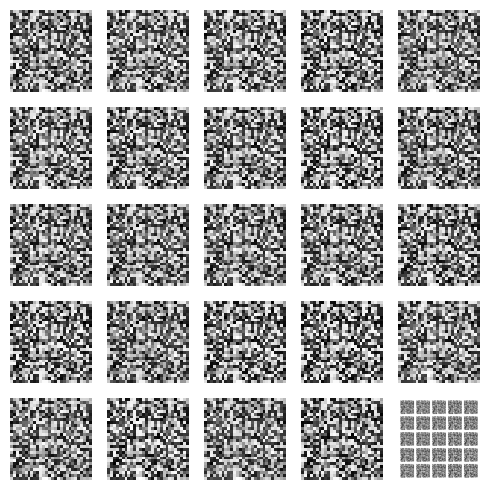

  0%|          | 0/350 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|          | 1/350 [00:00<05:39,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|          | 2/350 [00:01<05:14,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|          | 3/350 [00:02<05:05,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|          | 4/350 [00:03<04:55,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  1%|▏         | 5/350 [00:04<04:48,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  2%|▏         | 6/350 [00:05<04:38,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  2%|▏         | 7/350 [00:05<04:32,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  2%|▏         | 8/350 [00:06<04:39,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  3%|▎         | 9/350 [00:07<04:46,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  3%|▎         | 10/350 [00:08<04:50,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  3%|▎         | 11/350 [00:09<04:52,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|▎         | 12/350 [00:10<04:50,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|▎         | 13/350 [00:11<05:20,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  4%|▍         | 14/350 [00:12<05:53,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  4%|▍         | 15/350 [00:13<06:14,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  5%|▍         | 16/350 [00:14<05:51,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  5%|▍         | 17/350 [00:15<05:31,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  5%|▌         | 18/350 [00:16<05:14,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|▌         | 19/350 [00:17<04:58,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  6%|▌         | 20/350 [00:18<04:48,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  6%|▌         | 21/350 [00:18<04:35,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  6%|▋         | 22/350 [00:19<04:28,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  7%|▋         | 23/350 [00:20<04:27,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  7%|▋         | 24/350 [00:21<04:33,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  7%|▋         | 25/350 [00:22<04:33,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  7%|▋         | 26/350 [00:23<04:33,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  8%|▊         | 27/350 [00:23<04:35,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  8%|▊         | 28/350 [00:25<05:08,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  8%|▊         | 29/350 [00:26<05:42,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  9%|▊         | 30/350 [00:27<06:05,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  9%|▉         | 31/350 [00:28<05:34,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  9%|▉         | 32/350 [00:29<05:06,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  9%|▉         | 33/350 [00:30<04:55,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 10%|▉         | 34/350 [00:31<04:45,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 10%|█         | 35/350 [00:31<04:40,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 10%|█         | 36/350 [00:32<04:34,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 11%|█         | 37/350 [00:33<04:37,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 11%|█         | 38/350 [00:34<04:35,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 11%|█         | 39/350 [00:35<04:26,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 11%|█▏        | 40/350 [00:36<04:19,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▏        | 41/350 [00:36<04:21,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 12%|█▏        | 42/350 [00:37<04:22,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 12%|█▏        | 43/350 [00:39<04:55,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 13%|█▎        | 44/350 [00:40<05:21,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 13%|█▎        | 45/350 [00:41<05:25,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 13%|█▎        | 46/350 [00:42<05:02,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 13%|█▎        | 47/350 [00:43<04:45,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 14%|█▎        | 48/350 [00:43<04:39,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 14%|█▍        | 49/350 [00:44<04:36,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 14%|█▍        | 50/350 [00:45<04:33,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 15%|█▍        | 51/350 [00:46<04:30,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 15%|█▍        | 52/350 [00:47<04:29,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 15%|█▌        | 53/350 [00:48<04:27,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 15%|█▌        | 54/350 [00:49<04:16,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|█▌        | 55/350 [00:50<04:08,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|█▌        | 56/350 [00:50<04:04,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 16%|█▋        | 57/350 [00:51<04:23,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 17%|█▋        | 58/350 [00:53<04:49,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 17%|█▋        | 59/350 [00:54<05:08,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 17%|█▋        | 60/350 [00:55<04:49,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 17%|█▋        | 61/350 [00:55<04:30,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 18%|█▊        | 62/350 [00:56<04:24,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 18%|█▊        | 63/350 [00:57<04:18,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 18%|█▊        | 64/350 [00:58<04:10,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 19%|█▊        | 65/350 [00:59<04:09,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 19%|█▉        | 66/350 [01:00<04:03,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 19%|█▉        | 67/350 [01:01<04:04,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 19%|█▉        | 68/350 [01:01<04:06,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 20%|█▉        | 69/350 [01:02<04:06,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 20%|██        | 70/350 [01:03<04:05,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 20%|██        | 71/350 [01:04<04:07,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 21%|██        | 72/350 [01:05<04:39,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 21%|██        | 73/350 [01:07<04:56,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 21%|██        | 74/350 [01:08<04:58,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 21%|██▏       | 75/350 [01:09<04:34,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 22%|██▏       | 76/350 [01:09<04:19,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 22%|██▏       | 77/350 [01:10<04:13,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 22%|██▏       | 78/350 [01:12<05:16,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██▎       | 79/350 [01:13<04:52,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██▎       | 80/350 [01:14<04:30,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 23%|██▎       | 81/350 [01:15<04:15,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██▎       | 82/350 [01:15<04:08,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|██▎       | 83/350 [01:16<04:05,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|██▍       | 84/350 [01:17<03:55,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|██▍       | 85/350 [01:18<04:20,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 25%|██▍       | 86/350 [01:20<04:48,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 25%|██▍       | 87/350 [01:21<04:54,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 25%|██▌       | 88/350 [01:22<04:28,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 25%|██▌       | 89/350 [01:22<04:11,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 26%|██▌       | 90/350 [01:23<04:05,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 26%|██▌       | 91/350 [01:24<04:00,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 26%|██▋       | 92/350 [01:25<03:49,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 27%|██▋       | 93/350 [01:26<03:48,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 27%|██▋       | 94/350 [01:27<03:49,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 27%|██▋       | 95/350 [01:28<03:45,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|██▋       | 96/350 [01:29<03:39,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 28%|██▊       | 97/350 [01:29<03:35,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 28%|██▊       | 98/350 [01:30<03:37,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 28%|██▊       | 99/350 [01:31<04:02,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 29%|██▊       | 100/350 [01:33<04:25,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 29%|██▉       | 101/350 [01:34<04:48,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 29%|██▉       | 102/350 [01:35<04:22,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 29%|██▉       | 103/350 [01:36<04:03,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|██▉       | 104/350 [01:37<03:54,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|███       | 105/350 [01:38<03:49,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 30%|███       | 106/350 [01:38<03:40,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|███       | 107/350 [01:39<03:33,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 31%|███       | 108/350 [01:40<03:30,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 31%|███       | 109/350 [01:41<03:28,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|███▏      | 110/350 [01:42<03:25,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 32%|███▏      | 111/350 [01:43<03:23,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 32%|███▏      | 112/350 [01:43<03:24,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 32%|███▏      | 113/350 [01:44<03:27,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 33%|███▎      | 114/350 [01:46<04:00,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 33%|███▎      | 115/350 [01:47<04:24,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 33%|███▎      | 116/350 [01:48<04:22,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 33%|███▎      | 117/350 [01:49<04:00,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 34%|███▎      | 118/350 [01:50<03:46,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 34%|███▍      | 119/350 [01:51<03:41,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 34%|███▍      | 120/350 [01:52<03:37,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 35%|███▍      | 121/350 [01:53<03:33,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 35%|███▍      | 122/350 [01:54<03:29,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 35%|███▌      | 123/350 [01:54<03:23,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 35%|███▌      | 124/350 [01:55<03:22,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 36%|███▌      | 125/350 [01:56<03:17,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 36%|███▌      | 126/350 [01:57<03:19,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 36%|███▋      | 127/350 [01:58<03:20,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 37%|███▋      | 128/350 [01:59<03:51,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 37%|███▋      | 129/350 [02:01<04:08,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 37%|███▋      | 130/350 [02:02<04:09,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 37%|███▋      | 131/350 [02:03<03:47,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 38%|███▊      | 132/350 [02:03<03:33,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 38%|███▊      | 133/350 [02:04<03:28,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|███▊      | 134/350 [02:05<03:24,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 39%|███▊      | 135/350 [02:06<03:23,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 39%|███▉      | 136/350 [02:07<03:15,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 39%|███▉      | 137/350 [02:08<03:10,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 39%|███▉      | 138/350 [02:09<03:12,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 40%|███▉      | 139/350 [02:10<03:13,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 40%|████      | 140/350 [02:11<03:11,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 40%|████      | 141/350 [02:12<03:07,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 41%|████      | 142/350 [02:13<03:30,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 41%|████      | 143/350 [02:14<03:48,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████      | 144/350 [02:15<04:00,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 41%|████▏     | 145/350 [02:16<03:39,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 42%|████▏     | 146/350 [02:17<03:23,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 42%|████▏     | 147/350 [02:18<03:14,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 42%|████▏     | 148/350 [02:19<03:04,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 43%|████▎     | 149/350 [02:20<03:05,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 43%|████▎     | 150/350 [02:21<02:59,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 43%|████▎     | 151/350 [02:21<02:54,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 43%|████▎     | 152/350 [02:22<02:55,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 44%|████▎     | 153/350 [02:23<02:59,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 44%|████▍     | 154/350 [02:24<03:00,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 44%|████▍     | 155/350 [02:25<03:01,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▍     | 156/350 [02:27<03:24,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 45%|████▍     | 157/350 [02:28<03:41,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 45%|████▌     | 158/350 [02:29<03:48,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 45%|████▌     | 159/350 [02:30<03:27,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 46%|████▌     | 160/350 [02:31<03:17,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 46%|████▌     | 161/350 [02:32<03:10,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 46%|████▋     | 162/350 [02:33<03:06,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 47%|████▋     | 163/350 [02:34<03:02,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 47%|████▋     | 164/350 [02:35<02:57,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 47%|████▋     | 165/350 [02:36<02:51,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 47%|████▋     | 166/350 [02:36<02:49,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 48%|████▊     | 167/350 [02:37<02:50,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 48%|████▊     | 168/350 [02:38<02:48,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 48%|████▊     | 169/350 [02:39<02:47,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 49%|████▊     | 170/350 [02:41<03:12,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 49%|████▉     | 171/350 [02:42<03:29,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 49%|████▉     | 172/350 [02:43<03:24,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 49%|████▉     | 173/350 [02:44<03:07,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|████▉     | 174/350 [02:45<02:57,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 50%|█████     | 175/350 [02:46<02:50,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 50%|█████     | 176/350 [02:47<02:42,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 51%|█████     | 177/350 [02:48<02:42,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 51%|█████     | 178/350 [02:49<02:43,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 51%|█████     | 179/350 [02:49<02:41,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 51%|█████▏    | 180/350 [02:50<02:35,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████▏    | 181/350 [02:51<02:31,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 52%|█████▏    | 182/350 [02:52<02:28,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 52%|█████▏    | 183/350 [02:53<02:36,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 53%|█████▎    | 184/350 [02:55<02:59,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 53%|█████▎    | 185/350 [02:56<03:15,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 186/350 [02:57<03:07,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 53%|█████▎    | 187/350 [02:58<02:51,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 54%|█████▎    | 188/350 [02:59<02:39,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 54%|█████▍    | 189/350 [03:00<02:32,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 54%|█████▍    | 190/350 [03:00<02:27,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 55%|█████▍    | 191/350 [03:01<02:23,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 55%|█████▍    | 192/350 [03:02<02:20,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 55%|█████▌    | 193/350 [03:03<02:22,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 55%|█████▌    | 194/350 [03:06<04:09,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


 56%|█████▌    | 195/350 [03:08<04:06,  1.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 56%|█████▌    | 196/350 [03:09<03:54,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 56%|█████▋    | 197/350 [03:10<03:32,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 57%|█████▋    | 198/350 [03:11<03:07,  1.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 57%|█████▋    | 199/350 [03:12<02:48,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 57%|█████▋    | 200/350 [03:13<02:34,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 57%|█████▋    | 201/350 [03:14<02:28,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 58%|█████▊    | 202/350 [03:15<02:23,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 58%|█████▊    | 203/350 [03:16<02:17,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 58%|█████▊    | 204/350 [03:16<02:14,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 59%|█████▊    | 205/350 [03:17<02:14,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|█████▉    | 206/350 [03:18<02:13,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 59%|█████▉    | 207/350 [03:19<02:14,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 59%|█████▉    | 208/350 [03:20<02:21,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 60%|█████▉    | 209/350 [03:22<02:39,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 60%|██████    | 210/350 [03:23<03:00,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 60%|██████    | 211/350 [03:25<02:49,  1.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 61%|██████    | 212/350 [03:26<02:41,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 61%|██████    | 213/350 [03:27<02:32,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 61%|██████    | 214/350 [03:28<02:24,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 61%|██████▏   | 215/350 [03:28<02:16,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 62%|██████▏   | 216/350 [03:29<02:10,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 62%|██████▏   | 217/350 [03:30<02:12,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


In [ ]:
# To see some progress, we use tqdm as a progress bar
from tqdm import tqdm

# Since we do NOT use fit
# sadly, we have to do this ourselves manually
history = {"discriminator":[],"generator":[]}

# Main training loop
for epoch_num in range(EPOCHS):
    epoch_discriminator_loss = 0
    epoch_generator_loss = 0

    for batch in tqdm(range(BATCH_NUM)):
        # We select randomly a half batch amount of real images from MNIST
        # Use Numpy to choose, no replacement!

        idx = np.random.choice(data.shape[0], HALF_BATCH, replace=False)
        real_images = data[idx]

        # We generate a half batch amount of fake images
        # By first generating a half batch worth of Gaussian noise with zero mean, unit variance
        # and appropriate noise dimensions
        input_noise = np.random.normal(0, 1, size=(HALF_BATCH, Z_DIM))
        # And then using the fixed generator, to output some images from it
        # Using the predict method of the generator!

        generated_images = generator.predict(input_noise)

         # We use predict, because we do not want to update the generator's weights here,
        # only to generate some images based on the current weights.
        # If we would use something else, like __call__ or fit,
        # the generator would be updated, which is not intended here.
        # STOP, and thik through, WHY predict?!
        # Then you can remove the ....

        # We generate our "labels"
        # Remember one sided label smoothing for the positive class!
        # Let's say with 0.9...
        # So please, generate a half batch sized, one dimensional matrix with ones, using numpy
        # and multiuply it by 0.9
        real_y = np.ones((HALF_BATCH, 1)) * 0.9
        # And generate a half batch worth of zeroes, again one dimensional matrix
        generated_y = np.zeros((HALF_BATCH, 1))


        ### We do the actual training!

        # First for the discriminator on the real data
        discriminator_loss_real = discriminator.train_on_batch(real_images, real_y)

        # Then on the fake data
        discriminator_loss_generated = discriminator.train_on_batch(generated_images, generated_y)

        # Then average the two losses
        discriminator_loss = (discriminator_loss_real + discriminator_loss_generated) / 2
        epoch_discriminator_loss += discriminator_loss

        ### We then update the generator
        # We use the discriminator that was trained a line above, and is frozen, as defined in the joint model

        # Please generate a new set of input noise, notice, it is a full batch!
        # Again, using numpy, normal distribution, zero mean, unit variance
        new_input_noise = np.random.normal(0, 1, size=(BATCH_SIZE, Z_DIM))

        # We try to convince the discriminator, that this is real data - which is not
        # So please generate a batch worht of one dimensional matrix filled with ones
        convincing_y = np.ones((BATCH_SIZE, 1))

        # Notice, no label smoothing!

        # Remember, the joint model takes in noise, does the generation, the discrimination, then computes loss
        # But the discriminator is frozen, so only the generator will get updated
        # It is "successful" if the discriminator predicts "real" - hence the convincing_y
        generator_loss = joint_model.train_on_batch(new_input_noise, convincing_y)
        epoch_generator_loss += generator_loss[0]

    # Loss printout in every epoch, averaged over the batches
    print("Epoch number:",epoch_num,"discriminator_loss:",epoch_discriminator_loss / BATCH_NUM, "generator_loss:", epoch_generator_loss / BATCH_NUM)

    # Save it for the future
    history["discriminator"].append(epoch_discriminator_loss / BATCH_NUM)
    history["generator"].append(epoch_generator_loss / BATCH_NUM)

    #Save model - optional
    generator.save("generator.h5")

    #Save images
    get_example_images(epoch_num)

    # Show epoch example
    show_image_for_epoch(epoch_num)

## Visualization of training progress

In [ ]:
plt.plot(history["discriminator"], color='blue', linewidth=2, label="Discriminator")
plt.plot(history["generator"],  color='red', linewidth=2, label="Generator")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
